In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import re
import warnings
from joblib import dump, load
from typing import List, Any, Dict
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.base import TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt


# to mute warnings
def warn(*args, **kwargs):
  pass

warnings.warn = warn

nltk.download('stopwords')





[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Loading dataset. You can use your own but make sure that column names are match.


In [3]:
df = pd.read_csv('./dataset_for_assignment.csv')
df.head()

,comment_text,target
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


Examples of class '1' is 16225 . Examples of class '0' is 143346
Ratio of classes:  0.1131876717871444


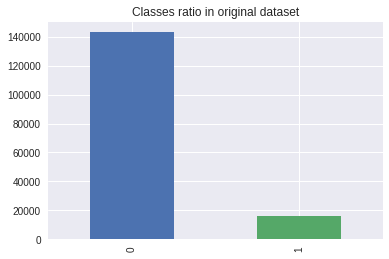

In [4]:
groups = df.groupby(['target']).agg({'target': 'count'}).to_dict('index')
print("Examples of class '1' is", groups[1]['target'], ". Examples of class '0' is", groups[0]['target'])
print("Ratio of classes: ", groups[1]['target'] / groups[0]['target'])
df.target.value_counts().plot(kind='bar', title='Classes ratio in original dataset');

We're going to use **F1** metric to compare and select model.

# Text pre-processing

In [5]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;\\n]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))


def clean_text(text: str) -> str:
    '''Clean text'''
       
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    text = BAD_SYMBOLS_RE.sub('', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text
    
df['comment_text'] = df['comment_text'].apply(clean_text)
df.head()


,comment_text,target
0,explanation edits made username hardcore metal...,0
1,daww matches background colour im seemingly st...,0
2,hey man im really trying edit war guy constant...,0
3,cant make real suggestions improvement wondere...,0
4,sir hero chance remember page thats,0


## Train and test dataset split

---



In [0]:
df_train, df_test = train_test_split(df, shuffle=True, test_size=0.15)

def mk_clf_report(
    pipeline: Pipeline, 
    parameters: Dict[str, Any], 
    df_train: pd.DataFrame, 
    df_test: pd.DataFrame,
    scoring='f1'
):
  ''' Do grid search using provided pipeline and parameters'''  
  X = df_train.comment_text.tolist()
  Y = df_train.target.tolist()
  
  gs = GridSearchCV(
      pipeline, 
      parameters, 
      cv=5, 
      iid=False, 
      n_jobs=-1, 
      scoring=scoring
  )
  
  gs = gs.fit(X, Y)
  
  # test
  predicted = gs.predict(df_test.comment_text.tolist())
  report = classification_report(
      y_true=df_test.target.tolist(), 
      y_pred=predicted
  )

  return gs, report
  


# Multinomial Naive Bayes


---



In [0]:
ppl = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1,1))),
    ('tfidf', TfidfTransformer(sublinear_tf=False)),
    ('clf', MultinomialNB(fit_prior=False)),
])

parameters = {
  'vect__ngram_range': [(1,1), (1,2), (2,2)],
  'tfidf__sublinear_tf': [True, False],
  'clf__fit_prior':      [True, False]
}


In [125]:
gs, report = mk_clf_report(ppl, parameters, df_train, df_test)
print(report)
print('Best params:', gs.best_params_)
print('Best score:', gs.best_score_)

              precision    recall  f1-score   support

           0       0.94      0.99      0.96     21493
           1       0.83      0.44      0.58      2443

   micro avg       0.93      0.93      0.93     23936
   macro avg       0.89      0.72      0.77     23936
weighted avg       0.93      0.93      0.92     23936

Best params: {'clf__fit_prior': False, 'tfidf__sublinear_tf': False, 'vect__ngram_range': (1, 1)}
Best score: 0.5722973218582064


# Bernuolli Naive Bayes
---

In [0]:
ppl = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1,1))),
    ('tfidf', TfidfTransformer(use_idf=True, sublinear_tf=False)),
    ('clf', BernoulliNB(binarize=0.0, fit_prior=True)),
])

parameters = {
  'vect__ngram_range': [(1,1), (1,2), (2,2)],
  'tfidf__sublinear_tf': [True, False],
  'clf__fit_prior': [True, False]
}



In [127]:
gs, report = mk_clf_report(ppl, parameters, df_train, df_test)
print(report)
print('Best params:', gs.best_params_)
print('Best score:', gs.best_score_)

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     21493
           1       0.85      0.55      0.67      2443

   micro avg       0.94      0.94      0.94     23936
   macro avg       0.90      0.77      0.82     23936
weighted avg       0.94      0.94      0.94     23936

Best params: {'clf__fit_prior': False, 'tfidf__sublinear_tf': True, 'vect__ngram_range': (1, 1)}
Best score: 0.628941406844671


# SVM & Logistic Regression
---

In [0]:
ppl = Pipeline([
    ('l0', CountVectorizer(ngram_range=(1,1))),
    ('l1', TfidfTransformer(use_idf=True, sublinear_tf=True)),
    ('l3', SGDClassifier(
        loss='hinge', 
        penalty='l2', 
        alpha=1e-5, 
        random_state=17, 
        max_iter=1000, 
        class_weight=None
    )),
])
parameters = {
  'l0__ngram_range': [(1,1), (1,2)],
  #'l1__sublinear_tf': [True, False],
  #'l3__alpha': [1e-5, 1e-4],
  'l3__loss': ['hinge', 'log'],
  #'l3__penalty': ['l2', 'l1'],
  'l3__class_weight': ['balanced', None]
}


In [8]:
gs, report = mk_clf_report(ppl, parameters, df_train, df_test)
print(report)
print('Best params:', gs.best_params_)
print('Best score:', gs.best_score_)
dump(gs.best_estimator_, 'SGDClassifier.joblib')

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     21484
           1       0.79      0.79      0.79      2452

   micro avg       0.96      0.96      0.96     23936
   macro avg       0.88      0.88      0.88     23936
weighted avg       0.96      0.96      0.96     23936

Best params: {'l0__ngram_range': (1, 2), 'l3__class_weight': 'balanced', 'l3__loss': 'hinge'}
Best score: 0.7942061412858454


['SGDClassifier.joblib']

# Conclusions

For selected metric we take SVM model as best we got.
